<a href="https://colab.research.google.com/github/Chinthanamj/MLGA-Team-4/blob/main/Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection

## Installation

In [ ]:
import torch
vers = torch.__version__
print("Torch vers: ", vers)

# PyG installation
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

import torch_geometric

Torch vers:  2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Dataset

- feature="content" --> Spacy Word2Vec + Profile features


In [ ]:
from torch_geometric.datasets import UPFD
train_data = UPFD(root=".", name="gossipcop", feature="content", split="test")
test_data = UPFD(root=".", name="gossipcop", feature="content", split="train")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))
total_data = train_data + test_data
print(f"Length of Total Data: {len(total_data)}")

Train Samples:  3826
Test Samples:  1092
Length of Total Data: 4918


### Investigating the News Propagation Graph

In [ ]:
print(train_data[0])
for i in range(2):
  print(train_data[i].edge_index)

Data(x=[116, 310], edge_index=[2, 115], y=[1])
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   7,  15,  15,  15,  15,  15,  41,  42,  42,  42,  42,  42,  42,
          42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,
          42,  42,  47],
        [  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
          15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
          29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
          43,  44,  45,  46,  47,  48,  49,  50,  51,  52, 

In [ ]:
!pip install networkx
import networkx as nx

# From PyG utils
def to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=False,
                remove_self_loops=False):
    if to_undirected:
        G = nx.Graph()
    else:
        G = nx.DiGraph()
    G.add_nodes_from(range(data.num_nodes))
    node_attrs, edge_attrs = node_attrs or [], edge_attrs or []
    values = {}
    for key, item in data(*(node_attrs + edge_attrs)):
        if torch.is_tensor(item):
            values[key] = item.squeeze().tolist()
        else:
            values[key] = item
        if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
            values[key] = item[0]
    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        if to_undirected and v > u:
            continue
        if remove_self_loops and u == v:
            continue
        G.add_edge(u, v)
        for key in edge_attrs:
            G[u][v][key] = values[key][i]
    for key in node_attrs:
        for i, feat_dict in G.nodes(data=True):
            feat_dict.update({key: values[key][i]})
    return G

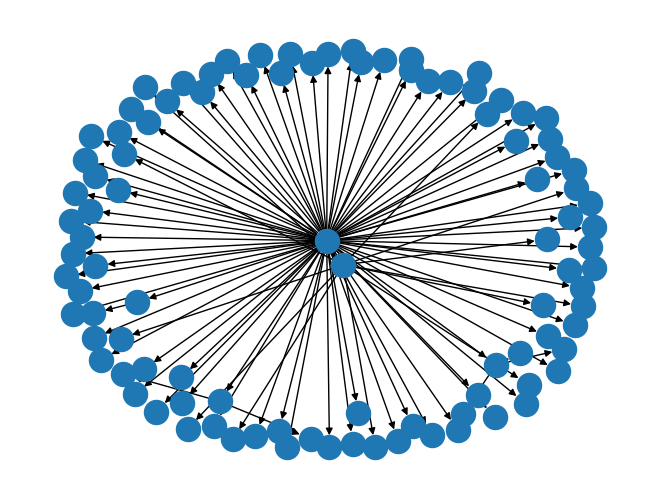

In [ ]:
# print(type(train_data))
# nx.draw(to_networkx(train_data))
G = to_networkx(train_data[2])
nx.draw(G)

### Node features

In [ ]:
for i in range(3):
  print(train_data[i].x)

tensor([[0.4762, 0.4986, 0.5922,  ..., 0.4608, 0.1049, 0.1725],
        [0.4536, 0.5054, 0.6587,  ..., 0.3151, 0.1111, 0.1618],
        [0.4762, 0.4986, 0.5922,  ..., 0.4608, 0.1049, 0.1725],
        ...,
        [0.5111, 0.5022, 0.4710,  ..., 0.2534, 0.0556, 0.4118],
        [0.3148, 0.4548, 0.5879,  ..., 0.5548, 0.1111, 0.2500],
        [0.5202, 0.4781, 0.4777,  ..., 0.8699, 0.0556, 0.2647]])
tensor([[0.4761, 0.5027, 0.5306,  ..., 0.5991, 0.0778, 0.0696],
        [0.4124, 0.5225, 0.4834,  ..., 0.7055, 0.0556, 0.1471],
        [0.4549, 0.4738, 0.5438,  ..., 0.5822, 0.0556, 0.1176],
        ...,
        [0.4383, 0.5227, 0.5393,  ..., 0.7945, 0.1111, 0.0000],
        [0.4861, 0.5169, 0.5136,  ..., 0.9452, 0.0556, 0.1618],
        [0.4932, 0.5114, 0.5421,  ..., 0.9178, 0.0556, 0.0882]])
tensor([[0.5088, 0.5156, 0.5358,  ..., 0.6308, 0.1086, 0.1264],
        [0.4455, 0.5350, 0.5522,  ..., 0.0890, 0.1111, 0.1324],
        [0.4417, 0.5409, 0.5583,  ..., 0.6301, 0.0556, 0.0588],
        ...,

### Checking Distribution

<Axes: >

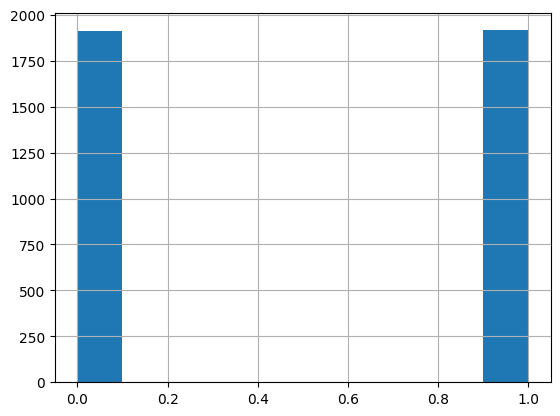

In [ ]:
import pandas as pd
labels = [data.y.item() for i, data in enumerate(train_data)]
df = pd.DataFrame(labels, columns=["Labels"])
df["Labels"].hist()

### Data Loaders

In [ ]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

## Model and Training

--> Because it is a directed graph, it will only share information from the root

In [ ]:
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GATConv
from torch.nn import Linear

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        # Graph Convolutions
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)

        # Readout
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2*hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Graph Convolutions
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()

        # Pooling
        h = gmp(h, batch)

        # Readout
        h = self.lin0(h).relu()

        # According to UPFD paper: Include raw word2vec embeddings of news
        # This is done per graph in the batch
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        # root is e.g. [   0,   14,   94,  171,  230,  302, ... ]
        news = x[root]
        news = self.lin_news(news).relu()

        out = self.lin1(torch.cat([h, news], dim=-1))
        return torch.sigmoid(out)

GNN(train_data.num_features, 128, 1)

GNN(
  (conv1): GATConv(310, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 128, heads=1)
  (lin_news): Linear(in_features=310, out_features=128, bias=True)
  (lin0): Linear(in_features=128, out_features=128, bias=True)
  (lin1): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())
    # Calculate Metrics
    accuracy, f1 = metrics(all_preds, all_labels)
    return total_loss / len(test_loader.dataset), accuracy, f1

def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts)
    return acc, f1

In [ ]:
loss_values = []
accuracy_values = []

for epoch in range(15):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | 'f'TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}')
    loss_values.append(test_loss)
    accuracy_values.append(test_acc)

Epoch: 00 |  TrainLoss: 0.71 | TestLoss: 0.68 | TestAcc: 0.53 | TestF1: 0.08
Epoch: 01 |  TrainLoss: 0.70 | TestLoss: 0.69 | TestAcc: 0.49 | TestF1: 0.66
Epoch: 02 |  TrainLoss: 0.68 | TestLoss: 0.74 | TestAcc: 0.49 | TestF1: 0.66
Epoch: 03 |  TrainLoss: 0.68 | TestLoss: 0.68 | TestAcc: 0.51 | TestF1: 0.00
Epoch: 04 |  TrainLoss: 0.64 | TestLoss: 0.59 | TestAcc: 0.90 | TestF1: 0.90
Epoch: 05 |  TrainLoss: 0.58 | TestLoss: 0.56 | TestAcc: 0.62 | TestF1: 0.72
Epoch: 06 |  TrainLoss: 0.51 | TestLoss: 0.45 | TestAcc: 0.91 | TestF1: 0.91
Epoch: 07 |  TrainLoss: 0.49 | TestLoss: 0.45 | TestAcc: 0.78 | TestF1: 0.71
Epoch: 08 |  TrainLoss: 0.43 | TestLoss: 0.38 | TestAcc: 0.91 | TestF1: 0.90
Epoch: 09 |  TrainLoss: 0.39 | TestLoss: 0.35 | TestAcc: 0.92 | TestF1: 0.92
Epoch: 10 |  TrainLoss: 0.35 | TestLoss: 0.32 | TestAcc: 0.93 | TestF1: 0.93
Epoch: 11 |  TrainLoss: 0.33 | TestLoss: 0.30 | TestAcc: 0.93 | TestF1: 0.93
Epoch: 12 |  TrainLoss: 0.32 | TestLoss: 0.29 | TestAcc: 0.93 | TestF1: 0.93

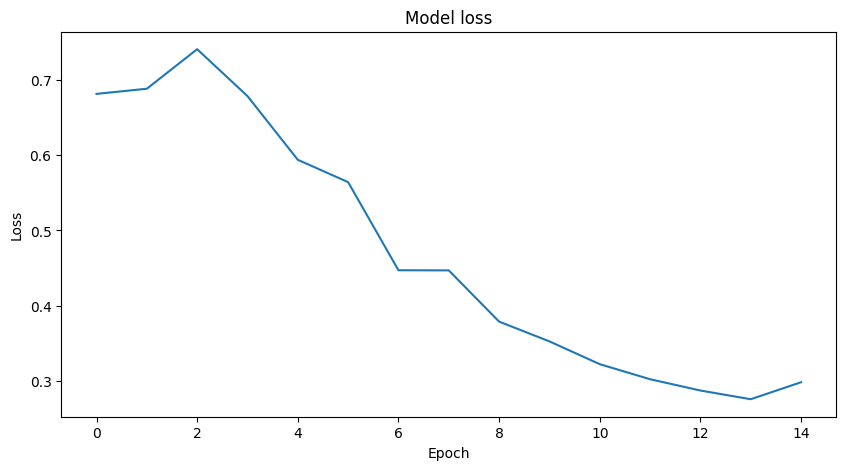

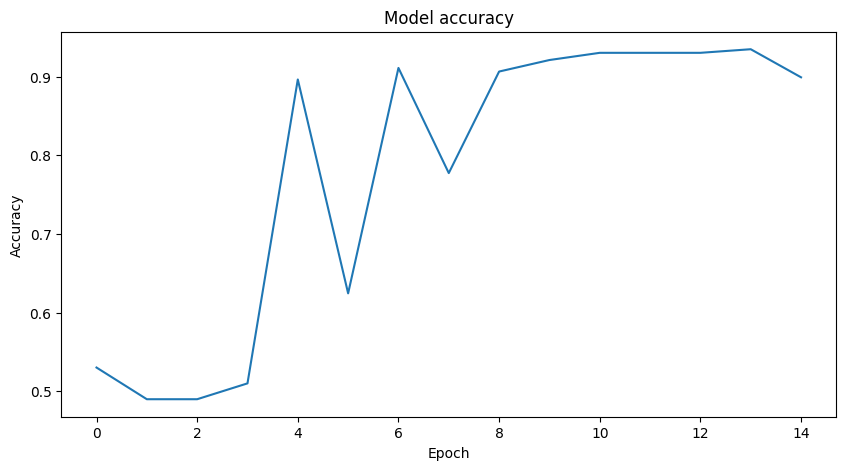

In [ ]:
import matplotlib.pyplot as plt

# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(loss_values)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Plotting the accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracy_values)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
for data in test_loader:
    data = data.to(device)
    pred = model(data.x, data.edge_index, data.batch)
    df = pd.DataFrame()
    df["pred_logit"] = pred.detach().numpy()[:,0]
    df["pred"] = torch.round(pred).detach().numpy()[:,0]
    df["true"] = data.y.numpy()
    print(df.head(10))
    break

   pred_logit  pred  true
0    0.073952   0.0     0
1    0.544001   1.0     1
2    0.973853   1.0     1
3    0.042468   0.0     0
4    0.064377   0.0     0
5    0.762648   1.0     1
6    0.636227   1.0     1
7    0.624202   1.0     1
8    0.103131   0.0     0
9    0.357514   0.0     1


# Using the Politifact Dataset now

62
221


<Axes: >

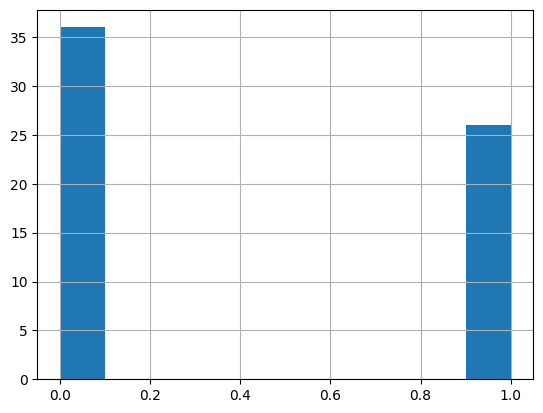

In [ ]:
from torch_geometric.datasets import UPFD
train_data = UPFD(root=".", name="politifact", feature="content", split="train")
test_data = UPFD(root=".", name="politifact", feature="content", split="test")
print(len(train_data))
print(len(test_data))

import pandas as pd
labels = [data.y.item() for i, data in enumerate(train_data)]
df = pd.DataFrame(labels, columns=["Labels"])
df["Labels"].hist()

In [ ]:
from torch_geometric.nn import global_mean_pool as gmp
# from torch_geometric.nn import GATConv
from torch_geometric.nn import SAGEConv
from torch.nn import Linear

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # Graph Convolutions
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        # Readout
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2*hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Graph Convolutions
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()
        # Pooling
        h = gmp(h, batch)
        # Readout
        h = self.lin0(h).relu()
        # According to UPFD paper: Include raw word2vec embeddings of news
        # This is done per graph in the batch
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        # root is e.g. [   0,   14,   94,  171,  230,  302, ... ]
        news = x[root]
        news = self.lin_news(news).relu()
        out = self.lin1(torch.cat([h, news], dim=-1))
        return torch.sigmoid(out)

GNN(train_data.num_features, 128, 1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())
    # Calculate Metrics
    accuracy, f1 = metrics(all_preds, all_labels)
    return total_loss / len(test_loader.dataset), accuracy, f1

def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts)
    return acc, f1

loss_values = []
accuracy_values = []

for epoch in range(25):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | 'f'TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}')
    loss_values.append(test_loss)
    accuracy_values.append(test_acc)

Epoch: 00 |  TrainLoss: 0.68 | TestLoss: 1.40 | TestAcc: 0.49 | TestF1: 0.00
Epoch: 01 |  TrainLoss: 1.16 | TestLoss: 0.72 | TestAcc: 0.49 | TestF1: 0.00
Epoch: 02 |  TrainLoss: 0.68 | TestLoss: 0.72 | TestAcc: 0.51 | TestF1: 0.68
Epoch: 03 |  TrainLoss: 0.77 | TestLoss: 0.70 | TestAcc: 0.51 | TestF1: 0.68
Epoch: 04 |  TrainLoss: 0.73 | TestLoss: 0.69 | TestAcc: 0.49 | TestF1: 0.00
Epoch: 05 |  TrainLoss: 0.69 | TestLoss: 0.73 | TestAcc: 0.49 | TestF1: 0.00
Epoch: 06 |  TrainLoss: 0.68 | TestLoss: 0.74 | TestAcc: 0.49 | TestF1: 0.00
Epoch: 07 |  TrainLoss: 0.69 | TestLoss: 0.72 | TestAcc: 0.49 | TestF1: 0.00
Epoch: 08 |  TrainLoss: 0.68 | TestLoss: 0.70 | TestAcc: 0.49 | TestF1: 0.00
Epoch: 09 |  TrainLoss: 0.68 | TestLoss: 0.70 | TestAcc: 0.49 | TestF1: 0.00
Epoch: 10 |  TrainLoss: 0.68 | TestLoss: 0.72 | TestAcc: 0.49 | TestF1: 0.00
Epoch: 11 |  TrainLoss: 0.68 | TestLoss: 0.72 | TestAcc: 0.49 | TestF1: 0.00
Epoch: 12 |  TrainLoss: 0.68 | TestLoss: 0.71 | TestAcc: 0.49 | TestF1: 0.00

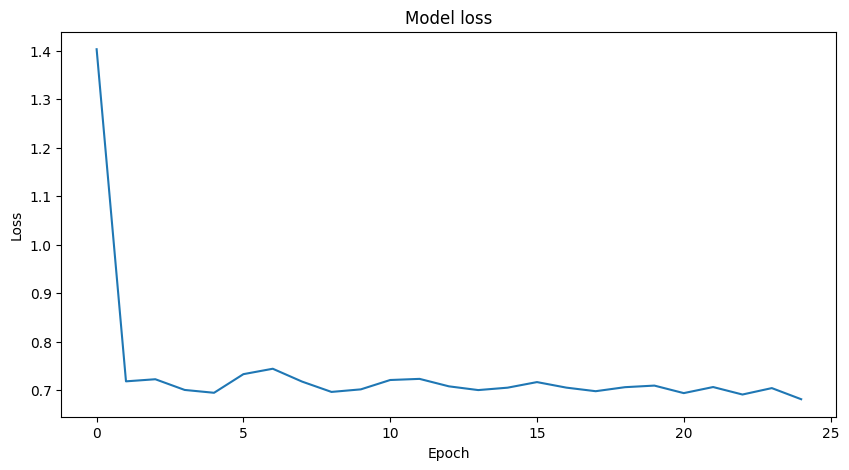

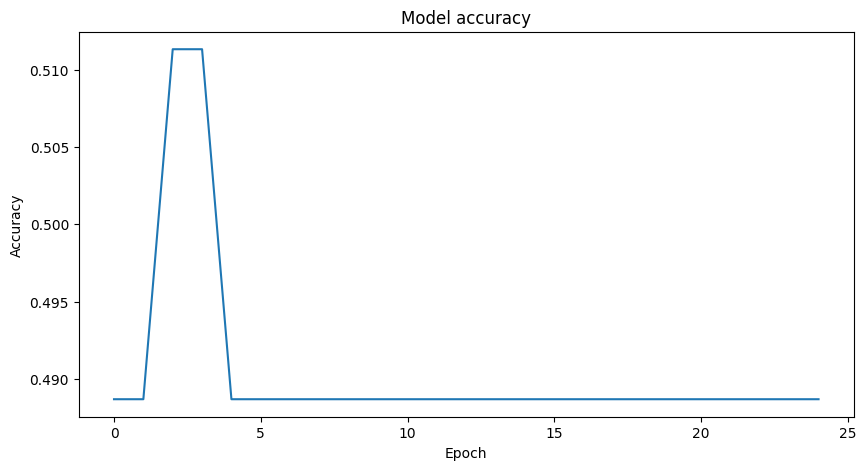

In [ ]:
import matplotlib.pyplot as plt

# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(loss_values)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Plotting the accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracy_values)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()